# Data Cleaning & Synthesizing New Data

## Data Cleaning

- Dt_Customer was stored as an object, changed the data type to datetime
- No duplicate customer IDs found
- Column Income contained 24 null values. Data distribution revealed skewness, hence replaced null values with median value
- Data contained unrealistc customers with birth year 1893. To ensure realiable analysis, the customer year of birth has been restricted to range 1950-present. This avoids skewing demographics with erroneous records
- Income showed extreme outliers, with values >600k while 99% of customers earned <100k. These were treated as data entry errors and removed to avoid skewing the analysis
- While few outliers were observed in NumWebVisitsMonth column, these were not removed as the values (~20) are not unrealistic
- Marital_Status had inconsistent categories (‘YOLO’, ‘Absurd’) which were removed (4 rows total). The category ‘Alone’ was merged into ‘Single’ for consistency.
- Education had multiple categories which are similar, converted them and made into consistent labels - Undergraduate, Graduate, Postgraduate
- Converted Dt_Customer to pandas datetime format
- Dropped irrelevant columns such as 'Z_CostContact', 'Z_Revenue'. These were generated by a predictive model as per the data owner

## Synthesizing New Data

- Original data consisted of 2k rows which is a small sample for meaningful analytics. Used CTGAN synthesizer model to create similar but fake data of 20k rows learning from the patterns of the base data

In [1]:
!pip install sdv

In [2]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# donwload base data from Kaggle directly

path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/customer-personality-analysis


In [5]:
base_df = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', sep='\t')
base_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
base_df['Dt_Customer'] = pd.to_datetime(
    base_df['Dt_Customer'],
    errors='coerce',
    dayfirst=True
)

print(base_df['Dt_Customer'].dtype)

datetime64[ns]


In [8]:
# checking for any duplicate values in ID column to ensure it is really unique

dup_count = base_df.duplicated(subset=['ID']).sum()
print(f"Duplicated rows in column ID: {dup_count}")

Duplicated rows in column ID: 0


## Checking and Replacing Null Values

In [9]:
# checking for null values

null_counts = base_df.isnull().sum()
cols_with_nulls = null_counts[null_counts > 0]

print(cols_with_nulls)

Income    24
dtype: int64


Skewness: 6.758908338860741


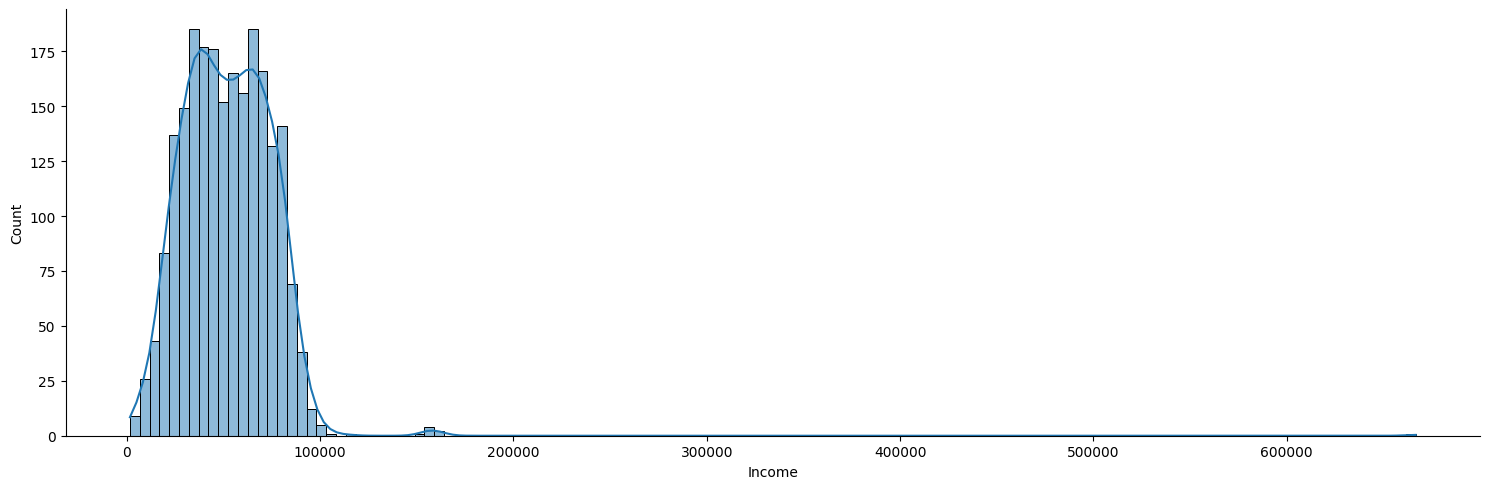

In [10]:
# checking the distribution of Income column to determine whether null values should be replaced by mean or median
sns.displot(data=base_df, x='Income', kde=True, height=5, aspect=3)

# confirming the skewness with Scipy - skewness coefficient is 6.75 which confirms strong right-skewed data as seen in the distribution plot
skewness_value = skew(base_df['Income'].dropna())
print(f"Skewness: {skewness_value}")

In [11]:
# imputing median values for the missing Income values as data is skewed

base_df['Income'] = base_df['Income'].fillna(base_df['Income'].median())

## Treating Outliers

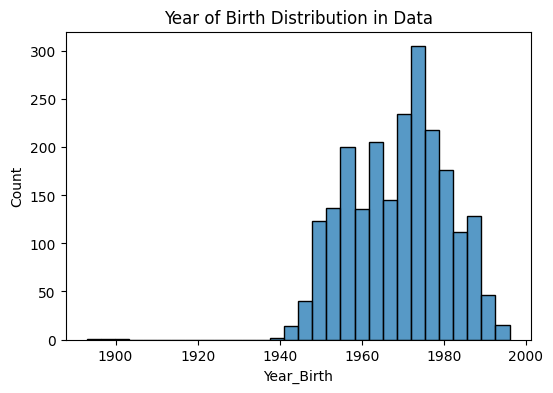

,Year_Birth
count,2240.000000
mean,1968.805804
std,11.984069
min,1893.000000
25%,1959.000000
50%,1970.000000
75%,1977.000000
max,1996.000000


In [12]:
# checking for unrealistic data in Year_Birth column

plt.figure(figsize=(6,4))
sns.histplot(base_df['Year_Birth'], bins=30, kde=False)
plt.title("Year of Birth Distribution in Data")
plt.show()

base_df['Year_Birth'].describe()

In [13]:
# removing unrealistic year of birth such as 1893

base_df = base_df[(base_df['Year_Birth'] >= 1950)]

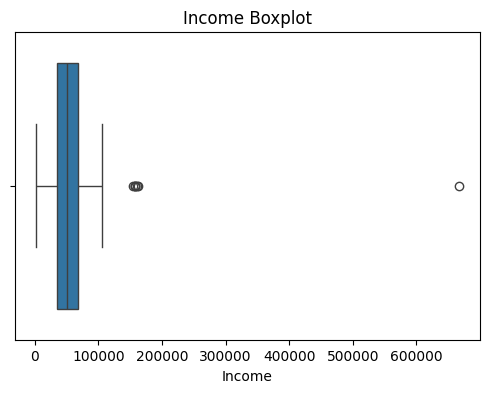

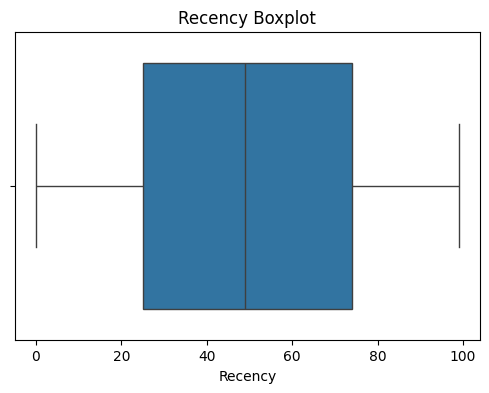

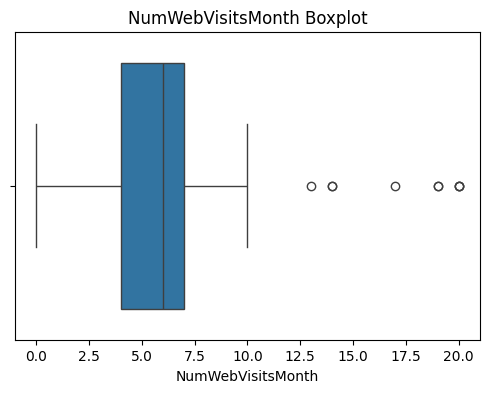

In [14]:
for cols in ['Income', 'Recency', 'NumWebVisitsMonth']:
  plt.figure(figsize=(6,4))
  sns.boxplot(x=base_df[cols])
  plt.title(f"{cols} Boxplot")
  plt.show()

In [15]:
base_df = base_df[(base_df['Income'] <= 200000)]

## Data Inconsistency Treatement

In [16]:
# checking for typos or inconsistencies in category labels

for cols in ['Education', 'Marital_Status']:
  print(f"Unique values in {cols}: ")
  print(base_df[cols].unique())

Unique values in Education: 
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Unique values in Marital_Status: 
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [17]:
base_df['Marital_Status'].value_counts()

,count
Marital_Status,
Married,824
Together,548
Single,466
Divorced,224
Widow,60
Alone,3
Absurd,2
YOLO,2


In [18]:
# removing 'YOLO' and 'Absurd'
base_df = base_df[~base_df['Marital_Status'].isin(['YOLO', 'Absurd'])]

# combining 'Alone' into 'Single'
base_df['Marital_Status'] = base_df['Marital_Status'].replace({'Alone': 'Single'})


# converting education categories into consistent labels
edu_mapping = {
    'Basic': 'Undergraduate',
    '2n Cycle': 'Undergraduate',
    'Graduation': 'Graduate',
    'Master': 'Postgraduate',
    'PhD': 'Postgraduate'
}

base_df['Education'] = base_df['Education'].replace(edu_mapping)

for cols in ['Education', 'Marital_Status']:
  print(f"Unique values in {cols}: ")
  print(base_df[cols].unique())

Unique values in Education: 
['Graduate' 'Postgraduate' 'Undergraduate']
Unique values in Marital_Status: 
['Single' 'Together' 'Married' 'Divorced' 'Widow']


### Dropping Irrelevant Columns

In [19]:
base_df = base_df.drop(columns=['Z_CostContact', 'Z_Revenue'])

### Synthesizing Data

In [20]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=base_df)
metadata.to_dict()

{'columns': {'ID': {'sdtype': 'id'},
  'Year_Birth': {'sdtype': 'numerical'},
  'Education': {'sdtype': 'categorical'},
  'Marital_Status': {'sdtype': 'categorical'},
  'Income': {'sdtype': 'numerical'},
  'Kidhome': {'sdtype': 'categorical'},
  'Teenhome': {'sdtype': 'categorical'},
  'Dt_Customer': {'sdtype': 'datetime'},
  'Recency': {'sdtype': 'numerical'},
  'MntWines': {'sdtype': 'numerical'},
  'MntFruits': {'sdtype': 'numerical'},
  'MntMeatProducts': {'sdtype': 'numerical'},
  'MntFishProducts': {'sdtype': 'numerical'},
  'MntSweetProducts': {'sdtype': 'numerical'},
  'MntGoldProds': {'sdtype': 'numerical'},
  'NumDealsPurchases': {'sdtype': 'numerical'},
  'NumWebPurchases': {'sdtype': 'numerical'},
  'NumCatalogPurchases': {'sdtype': 'numerical'},
  'NumStorePurchases': {'sdtype': 'numerical'},
  'NumWebVisitsMonth': {'sdtype': 'numerical'},
  'AcceptedCmp3': {'sdtype': 'categorical'},
  'AcceptedCmp4': {'sdtype': 'categorical'},
  'AcceptedCmp5': {'sdtype': 'categorical'},


In [21]:
synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(base_df)
synthetic_df = synthesizer.sample(num_rows=20000)
synthetic_df.reset_index(drop=True, inplace=True)

In [22]:
synthetic_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
ID,20000.0,8413638.26315,246.0,4249539.0,8421478.0,12610353.0,16776494.0,4832002.599458
Year_Birth,20000.0,1969.52995,1950.0,1961.0,1970.0,1978.0,1996.0,11.784916
Income,20000.0,39977.434645,1730.0,12456.95,38429.0,63630.7,111028.4,29251.920167
Kidhome,20000.0,0.4251,0.0,0.0,0.0,1.0,2.0,0.555883
Teenhome,20000.0,0.3734,0.0,0.0,0.0,1.0,2.0,0.557035
Dt_Customer,20000,2013-05-19 00:26:55.679999744,2012-07-30 00:00:00,2012-10-29 00:00:00,2013-04-03 00:00:00,2013-12-06 00:00:00,2014-06-29 00:00:00,NaN
Recency,20000.0,36.16205,0.0,6.0,31.0,63.0,99.0,30.590487
MntWines,20000.0,475.6258,0.0,40.0,279.0,841.0,1492.0,500.535421
MntFruits,20000.0,37.45845,0.0,5.0,16.0,39.0,199.0,51.501743
MntMeatProducts,20000.0,203.8062,0.0,49.0,116.0,213.25,1339.0,252.787253


In [23]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   20000 non-null  int64         
 1   Year_Birth           20000 non-null  int64         
 2   Education            20000 non-null  object        
 3   Marital_Status       20000 non-null  object        
 4   Income               20000 non-null  float64       
 5   Kidhome              20000 non-null  int64         
 6   Teenhome             20000 non-null  int64         
 7   Dt_Customer          20000 non-null  datetime64[ns]
 8   Recency              20000 non-null  int64         
 9   MntWines             20000 non-null  int64         
 10  MntFruits            20000 non-null  int64         
 11  MntMeatProducts      20000 non-null  int64         
 12  MntFishProducts      20000 non-null  int64         
 13  MntSweetProducts     20000 non-

In [24]:
expanded_df = pd.concat([base_df, synthetic_df], ignore_index=True)

In [25]:
expanded_df.to_csv("processed_data.csv")